In [79]:
import os
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Hyperparametres d'entrainement


In [6]:
INIT_LR = 1e-4
epochs = 20
batch_Size = 32

In [46]:
dataset_Foldre = "Mask_Dataset"
dataset_Classes = ["with_mask","without_mask"]
data = []
labels = []
for folder in dataset_Classes:
    path = os.path.join(dataset_Foldre,folder)
    category_num = dataset_Classes.index(folder)
    for image_name in os.listdir(path):
        image_path = os.path.join(path,image_name)
        image = load_img(image_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)
        data.append(image)
        labels.append(category_num)        

data = np.array(data, dtype="float32")
labels = np.array(labels)
        
    

In [47]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)


In [48]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

In [49]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(rotation_range=20,
zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15,horizontal_flip=True,fill_mode="nearest")

In [55]:
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

C:\Users\abdeslem\anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Instructions for updating:
Colocations handled automatically by placer.
9412608/9406464 [==============================] - 157s 17us/step


In [58]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [61]:
model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
    layer.trainable = False

In [65]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalizationV1) (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

In [66]:
new_model = model.fit(aug.flow(trainX, trainY, batch_size=batch_Size), steps_per_epoch=len(trainX) // batch_Size,
                      validation_data=(testX, testY),validation_steps=len(testX) // batch_Size, epochs=EPOCHS)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
35/35 [==============================] - 350s 10s/step - loss: 0.6993 - acc: 0.6045 - val_loss: 0.4904 - val_acc: 0.7391
Epoch 2/20
35/35 [==============================] - 353s 10s/step - loss: 0.4057 - acc: 0.8136 - val_loss: 0.2535 - val_acc: 0.9420
Epoch 3/20
35/35 [==============================] - 406s 12s/step - loss: 0.3015 - acc: 0.8736 - val_loss: 0.2164 - val_acc: 0.9457
Epoch 4/20
35/35 [==============================] - 403s 12s/step - loss: 0.2508 - acc: 0.9091 - val_loss: 0.1390 - val_acc: 0.9710
Epoch 5/20
35/35 [==============================] - 319s 9s/step - loss: 0.2162 - acc: 0.9155 - val_loss: 0.1075 - val_acc: 0.9819
Epoch 6/20
35/35 [==============================] - 313s 9s/step - loss: 0.2008 - acc: 0.9200 - val_loss: 0.1223 - val_acc: 0.9638
Epoch 7/20
35/35 [==============================] - 335s 10s/step - loss: 0.1467 - acc: 0.9500 - val_loss: 0.0866 - val_acc: 0.9819
Epoch 8/20
35/35 [============

In [85]:
model.save("new_mobilenet.model")

In [68]:
predict_model = model.predict(testX, batch_size=batch_Size)

In [73]:
prediction = np.argmax(predict_model,axis=1)

In [77]:
print(type(prediction))

<class 'numpy.ndarray'>


In [78]:
print(classification_report(testY.argmax(axis=1), prediction))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       138
           1       1.00      0.98      0.99       138

    accuracy                           0.99       276
   macro avg       0.99      0.99      0.99       276
weighted avg       0.99      0.99      0.99       276



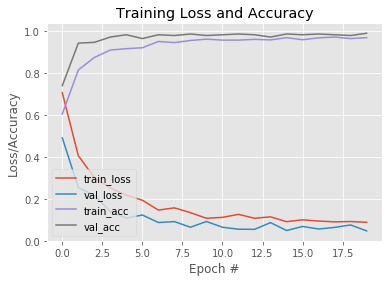

In [83]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, EPOCHS), new_model.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), new_model.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, EPOCHS), new_model.history["acc"], label="train_acc")
plt.plot(np.arange(0, EPOCHS), new_model.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")